In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMutils.util_RM import get_rmsf_planes
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from astropy.io import ascii
from astropy import units as u
from scipy.signal import find_peaks

In [2]:
freq_table = ascii.read('good_freq_400_729.txt')
freq_table['freq'] * u.MHz
freq_chime = (freq_table['freq'] * u.MHz).value
lsq_chime = (3e8/freq_chime)**2
rmsfplanes_chime = get_rmsf_planes(lsq_chime, np.arange(-100,100,0.1))

In [3]:
freq_150 = np.arange(138e6, 156e6, 9.8e3)
lsq_150 = (3e8/freq_150)**2
rmsfplanes_150 = get_rmsf_planes(lsq_150, np.arange(-100,100,0.1))

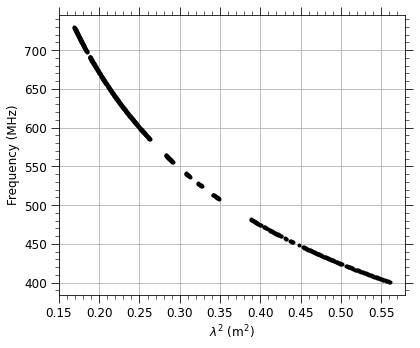

In [4]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(lsq_chime, freq_chime/1e6, 'k.')
ax.set_xlabel('$\lambda^2$ (m$^2$)')
ax.set_ylabel('Frequency (MHz)')
ax.grid()
fig.tight_layout()
fig.savefig('figures/nu_lsq.pdf')

In [5]:
freq = np.arange(400e6,729e6,390e3)
lsq = (3e8/freq)**2

In [6]:
rmsfplanes_out = get_rmsf_planes(lsq, np.arange(-100,100,0.1))

In [7]:
rmsfplanes_out

(array([-0.00865229+0.01086172j, -0.00904411+0.01042645j,
        -0.00943363+0.00998491j, ..., -0.00982055-0.00953751j,
        -0.00943363-0.00998491j, -0.00904411-0.01042645j]),
 array([-200. , -199.9, -199.8, ...,  199.7,  199.8,  199.9]),
 array(9.668173, dtype=float32),
 array(-1))

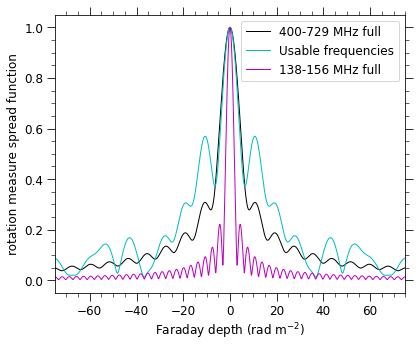

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), 'k', label='400-729 MHz full')
ax.plot(rmsfplanes_chime[1], np.abs(rmsfplanes_chime[0]), 'c', label='Usable frequencies')
ax.plot(rmsfplanes_150[1], np.abs(rmsfplanes_150[0]), 'm', label='138-156 MHz full')
#ax.plot(rmsfplanes_out[1], rmsfplanes_out[0].real, 'k--', label='full real')
#ax.plot(rmsfplanes_out[1], rmsfplanes_out[0].imag, 'k:', label='full imag')
ax.legend()
ax.set_xlabel('Faraday depth (rad m$^{-2}$)')
ax.set_ylabel('rotation measure spread function')
ax.set_xlim(-75,75)
fig.tight_layout()
fig.savefig('figures/rmsf.pdf')

In [9]:
rmsfplanes_out[1]

array([-200. , -199.9, -199.8, ...,  199.7,  199.8,  199.9])

In [10]:
rmsfplanes_out[1][20]

-197.99999999999443

In [11]:
rmsfplanes_out[1][40]

-195.99999999999454

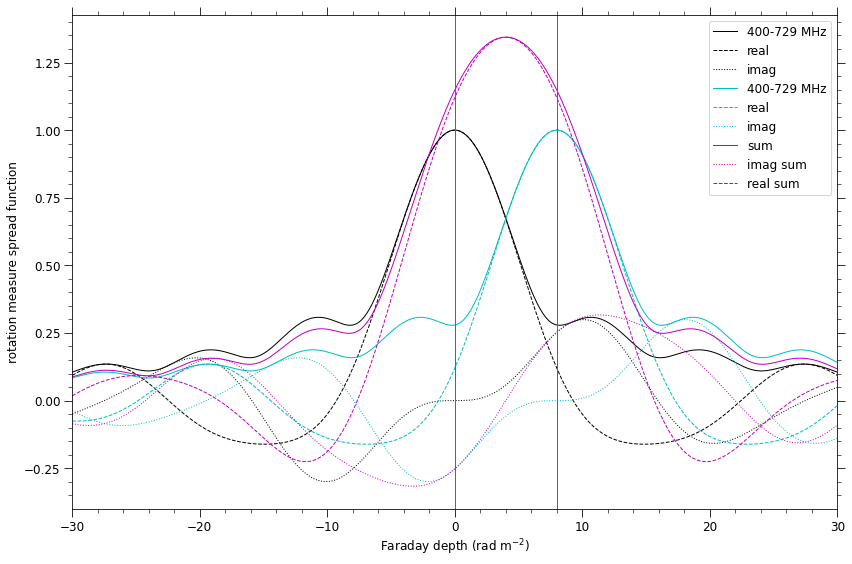

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), 'k', label='400-729 MHz')
ax.plot(rmsfplanes_out[1], rmsfplanes_out[0].real, 'k--', label='real')
ax.plot(rmsfplanes_out[1], rmsfplanes_out[0].imag, 'k:', label='imag')

ax.plot(rmsfplanes_out[1]+8, np.abs(rmsfplanes_out[0]), 'c', label='400-729 MHz')
ax.plot(rmsfplanes_out[1]+8, rmsfplanes_out[0].real, 'c--', label='real')
ax.plot(rmsfplanes_out[1]+8, rmsfplanes_out[0].imag, 'c:', label='imag')

ax.plot(rmsfplanes_out[1][80:], np.abs(rmsfplanes_out[0][80:] + rmsfplanes_out[0][:-80]), 'm-', label='sum')
ax.plot(rmsfplanes_out[1][80:], rmsfplanes_out[0][80:].imag + rmsfplanes_out[0][:-80].imag, 'm:', label='imag sum')
ax.plot(rmsfplanes_out[1][80:], rmsfplanes_out[0][80:].real + rmsfplanes_out[0][:-80].real, 'm--', label='real sum')

ax.axvline(x=0)
ax.axvline(x=8)

ax.legend()
ax.set_xlabel('Faraday depth (rad m$^{-2}$)')
ax.set_ylabel('rotation measure spread function')
ax.set_xlim(-30,30)
fig.tight_layout()
fig.savefig('figures/rmsf_complex.pdf')

In [13]:
def sims(ax, freq, phi_main, phi_2, pi_main=1, pi_2=0, dirty=False, clean=True, dPhi_radm2=0.1,
        cutoff=0.2, psi_2=0, sigma_1=0, sigma_2=0, plotqu=False, rmsynth_out=0, model_no = 1,
        legendnum = True, legendphi = False, legendchi = False, legendpi = False, legendsig=False,
        printtable=True, plot=True):
    
    P = pi_main * np.exp(2j*(phi_main * lsq)) * np.exp(-2 * sigma_1**2 * lsq**2) + pi_2 * np.exp(2j*(phi_2 * lsq - psi_2)) * np.exp(-2 * sigma_2**2 * lsq**2)
    rmsynth_out = run_rmsynth([freq, P.real, P.imag,
                       np.ones_like(P.real)*0.01, np.ones_like(P.imag)*0.01],
                             dPhi_radm2=dPhi_radm2, phiMax_radm2=100)
    if printtable:
        print(r'{:.0f} & ${:.1f}$ & ${:.0f} \radmsq$ & ${:.1f} \radmsq$ & $0\arcdeg$ & ${:.1f}$ & ${:.0f} \radmsq$ & ${:.1f} \radmsq$ & ${:.0f}\arcdeg$ \\'.format(
            model_no, pi_main,  phi_main,          sigma_1,                        pi_2,      phi_2,             sigma_2,           psi_2 * 180/np.pi))

    if plot:
        if dirty:
            p = ax.plot(rmsynth_out[1]['phiArr_radm2'], np.abs(rmsynth_out[1]['dirtyFDF']), linestyle='-.')
        else:
            p = ax.plot([0],[0])
        ax.axvline(x=phi_main, linestyle=':', color=p[0].get_color())
        ax.axvline(x=phi_2, linestyle=':', color=p[0].get_color())

        label = ''
        if legendnum:
            label += 'model {:.0f}'.format(model_no)
        if legendphi:
            label += ' $\Delta \phi = {:.0f}$'.format(np.abs(phi_2 - phi_main))

        if legendchi:
            label += ' $\Delta \chi = {:.0f}^\circ$'.format(np.abs(psi_2)*180/np.pi)

        if legendpi:
            label += ' $p_2/p_1 = {:.1f}$'.format(pi_2 / pi_main)

        if legendsig:
            label += ' $\sigma_2 = {:.0f}$'.format(sigma_2)
        
    if clean:
        clean_out = run_rmclean(rmsynth_out[0], rmsynth_out[1], cutoff)
        
        if plot:
            ax.plot(clean_out[1]['phiArr_radm2'], np.abs(clean_out[1]['cleanFDF']),
               color=p[0].get_color(), linestyle='-',
                   label = label)
            if plotqu:
                ax.plot(clean_out[1]['phiArr_radm2'], clean_out[1]['cleanFDF'].real,
                    color=p[0].get_color(), linestyle=':')
                ax.plot(clean_out[1]['phiArr_radm2'], clean_out[1]['cleanFDF'].imag,
                    color=p[0].get_color(), linestyle='--')
        return clean_out
    else:
        return rmsynth_out

0 & $1.0$ & $-5 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $0.0$ & $-5 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


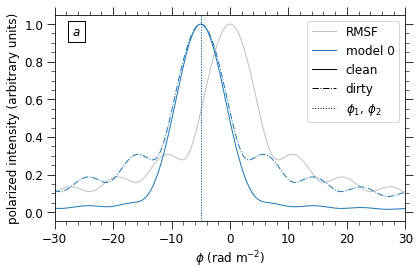

In [14]:
fig, ax = plt.subplots()

clean=True

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

clean_out = sims(ax, freq, -5, -5, pi_main=1, pi_2=0, psi_2 = 0,
     dirty=True, clean=clean, model_no=0)

handles, labels = ax.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='k', linestyle='-', label='clean'))
handles.append(Line2D([0], [0], color='k', linestyle='-.', label='dirty'))
handles.append(Line2D([0], [0], color='k', linestyle=':', label=r'$\phi_1$, $\phi_2$'))
ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.text(0.05, 0.9, '$a$', transform=ax.transAxes,
       bbox=dict(facecolor='w', edgecolor='k'))

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.tight_layout()
fig.savefig('figures/model_control.pdf')

In [15]:
clean_out[1].keys()

dict_keys(['phiArr_radm2', 'freqArr_Hz', 'cleanFDF', 'ccArr', 'iterCountArr', 'residFDF'])

/var/folders/9j/y_cnjkqx70q1nnvl1xdp91t40000gq/T/ipykernel_68121/1002392671.py:27: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(phi, np.sin((phi-4) * 0.19) / ((phi-4) * 0.19), 'k-')


(-30.0, 30.0)

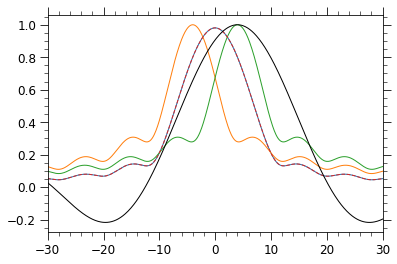

In [16]:
phi_main=-4
phi_2 = 4
psi_2 = 0

P1 = np.exp(2j*(phi_main * lsq))
P2 = np.exp(2j*(phi_2 * lsq - psi_2))
P = P1+P2

rmsynth_out1 = run_rmsynth([freq, P1.real, P1.imag,
                   np.ones_like(P1.real)*0.01, np.ones_like(P1.imag)*0.01],
                         dPhi_radm2=0.1, phiMax_radm2=100)
rmsynth_out2 = run_rmsynth([freq, P2.real, P2.imag,
                   np.ones_like(P2.real)*0.01, np.ones_like(P2.imag)*0.01],
                         dPhi_radm2=0.1, phiMax_radm2=100)
rmsynth_out = run_rmsynth([freq, P.real, P.imag,
                   np.ones_like(P.real)*0.01, np.ones_like(P.imag)*0.01],
                         dPhi_radm2=0.1, phiMax_radm2=100)

fig, ax = plt.subplots()
for r in [rmsynth_out, rmsynth_out1, rmsynth_out2]:
    p = ax.plot(r[1]['phiArr_radm2'], np.abs(r[1]['dirtyFDF']))

ax.plot(rmsynth_out[1]['phiArr_radm2'], np.abs(rmsynth_out1[1]['dirtyFDF'] + rmsynth_out2[1]['dirtyFDF']), '--')

phi = rmsynth_out[1]['phiArr_radm2']
phid = phi
ax.plot(phi, np.sin((phi-4) * 0.19) / ((phi-4) * 0.19), 'k-')
    
ax.set_xlim(-30,30)

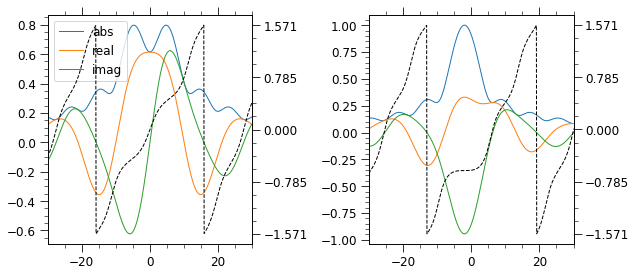

In [17]:
phi_main=-2
phi_2 = 2
psi_2 = 0

P1 = np.exp(2j*(phi_main * lsq))
P2 = np.exp(2j*(phi_2 * lsq - psi_2))
P = P1+P2

rmsynth_out = run_rmsynth([freq, P.real, P.imag,
                   np.ones_like(P.real)*0.01, np.ones_like(P.imag)*0.01],
                         dPhi_radm2=0.1, phiMax_radm2=100)

fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(9,4))
p = ax.plot(rmsynth_out[1]['phiArr_radm2'], np.abs(rmsynth_out[1]['dirtyFDF']), label='abs')
ax.plot(rmsynth_out[1]['phiArr_radm2'], rmsynth_out[1]['dirtyFDF'].real, label='real')
ax.plot(rmsynth_out[1]['phiArr_radm2'], rmsynth_out[1]['dirtyFDF'].imag, label='imag')

axr = ax.twinx()
pa = 0.5*(np.arctan2(rmsynth_out[1]['dirtyFDF'].imag, rmsynth_out[1]['dirtyFDF'].real))
axr.plot(rmsynth_out[1]['phiArr_radm2'], pa, 'k--', label='PA')
axr.yaxis.set_major_locator(MultipleLocator(np.pi/4))
#axr.set_ylim(-np.pi,np.pi)

ax.legend()

phi = rmsynth_out[1]['phiArr_radm2']
phid = phi
#ax.plot(phi, np.sin((phi-4) * 0.19) / ((phi-4) * 0.19), 'k-')
    
ax.set_xlim(-30,30)

P = P1

rmsynth_out = run_rmsynth([freq, P.real, P.imag,
                   np.ones_like(P.real)*0.01, np.ones_like(P.imag)*0.01],
                         dPhi_radm2=0.1, phiMax_radm2=100)

p = ax2.plot(rmsynth_out[1]['phiArr_radm2'], np.abs(rmsynth_out[1]['dirtyFDF']))
ax2.plot(rmsynth_out[1]['phiArr_radm2'], rmsynth_out[1]['dirtyFDF'].real)
ax2.plot(rmsynth_out[1]['phiArr_radm2'], rmsynth_out[1]['dirtyFDF'].imag)

axr = ax2.twinx()
pa = 0.5*(np.arctan2(rmsynth_out[1]['dirtyFDF'].imag, rmsynth_out[1]['dirtyFDF'].real))
axr.plot(rmsynth_out[1]['phiArr_radm2'], pa, 'k--')
axr.yaxis.set_major_locator(MultipleLocator(np.pi/4))
ax2.set_xlim(-30,30)
fig.tight_layout()

In [18]:
def phi_diff(dphi, dpsi):
    P1 = np.exp(2j*(-dphi/2 * lsq))
    P2 = np.exp(2j*(dphi/2 * lsq - dpsi))
    P = P1+P2
    
    rmsynth_out1 = run_rmsynth([freq, P1.real, P1.imag,
                       np.ones_like(P1.real)*0.01, np.ones_like(P1.imag)*0.01],
                             dPhi_radm2=0.1, phiMax_radm2=100)
    rmsynth_out2 = run_rmsynth([freq, P2.real, P2.imag,
                       np.ones_like(P2.real)*0.01, np.ones_like(P2.imag)*0.01],
                             dPhi_radm2=0.1, phiMax_radm2=100)
    pa1 = 0.5*np.unwrap(np.arctan2(rmsynth_out1[1]['dirtyFDF'].imag, rmsynth_out1[1]['dirtyFDF'].real))
    pa2 = 0.5*np.unwrap(np.arctan2(rmsynth_out2[1]['dirtyFDF'].imag, rmsynth_out2[1]['dirtyFDF'].real))
    return pa2-pa1

1 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


(-30.0, 30.0)

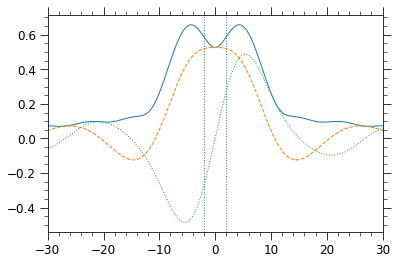

In [19]:
fig, ax = plt.subplots()
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, legendphi=True, model_no=1)
ax.plot(clean_out[1]['phiArr_radm2'], clean_out[1]['cleanFDF'].real, '--')
ax.plot(clean_out[1]['phiArr_radm2'], clean_out[1]['cleanFDF'].imag, ':')

ax.set_xlim(-30,30)

In [20]:
P = np.exp(2j*-7*lsq) + np.exp(2j*-2*lsq)

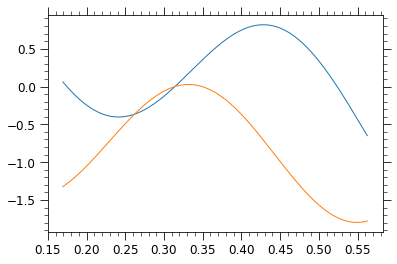

In [21]:
plt.plot(lsq, P.real)
plt.plot(lsq, P.imag)

1 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


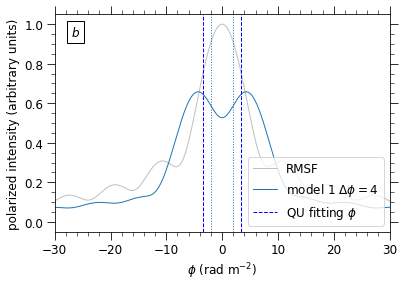

In [22]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, legendphi=True, model_no=1)
dphi = -0.4966 - (-7.215)
ax.axvline(x=-dphi/2, color='blue', linestyle='--', label='QU fitting $\phi$')
ax.axvline(x=dphi/2, color='blue', linestyle='--')

handles, labels = ax.get_legend_handles_labels()

#handles.append(Line2D([0], [0], color='k', linestyle='-', label='clean'))
#handles.append(Line2D([0], [0], color='k', linestyle='-.', label='dirty'))
ax.set_xlim(-30, 30)
ax.legend(handles=handles, loc='lower right')

ax.text(0.05, 0.9, '$b$', transform=ax.transAxes,
       bbox=dict(facecolor='w', edgecolor='k'))

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.savefig('figures/model_clean.pdf')

1 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
2 & $1.0$ & $-5 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $5 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
3 & $1.0$ & $-10 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $10 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


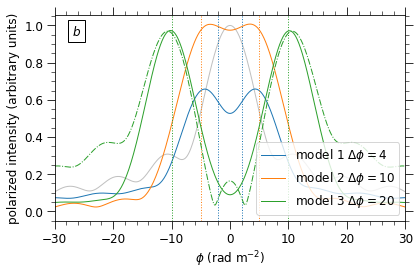

In [23]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0')#, label='RMSF')

clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, legendphi=True, model_no=1)
clean_out = sims(ax, freq, -5, 5, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, legendphi=True, model_no=2)
clean_out = sims(ax, freq, -10, 10, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=True, clean=clean, legendphi=True, model_no=3)

handles, labels = ax.get_legend_handles_labels()

#handles.append(Line2D([0], [0], color='k', linestyle='-', label='clean'))
#handles.append(Line2D([0], [0], color='k', linestyle='-.', label='dirty'))
ax.set_xlim(-30, 30)
ax.legend(handles=handles, loc='lower right')

ax.text(0.05, 0.9, '$b$', transform=ax.transAxes,
       bbox=dict(facecolor='w', edgecolor='k'))

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.tight_layout()
fig.savefig('figures/model_clean.pdf')

1 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
4 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $45\arcdeg$ \\
5 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\


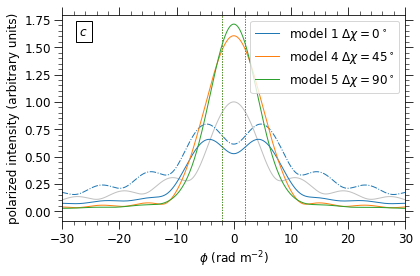

In [24]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0')#, label='RMSF')

clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=True, clean=True, model_no=1, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = np.pi/4,
     dirty=False, clean=True, model_no=4, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = np.pi/2,
     dirty=False, clean=True, model_no=5, legendchi=True)

handles, labels = ax.get_legend_handles_labels()

#handles.append(Line2D([0], [0], color='k', linestyle='-', label='clean'))
#handles.append(Line2D([0], [0], color='k', linestyle='-.', label='dirty'))

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.text(0.05, 0.9, '$c$', transform=ax.transAxes,
       bbox=dict(facecolor='w', edgecolor='k'))

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.tight_layout()
fig.savefig('figures/model_angles.pdf')

In [25]:
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=True, clean=True, model_no=1, legendchi=True)

1 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


6 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $0.5$ & $2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
7 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $0.5$ & $2 \radmsq$ & $0.0 \radmsq$ & $45\arcdeg$ \\
8 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $0.5$ & $2 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\


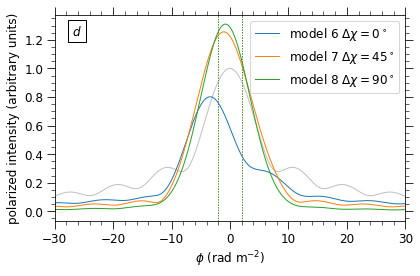

In [26]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0')#, label='RMSF')

clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=0.5, psi_2 = 0,
     dirty=False, clean=True, model_no=6, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1/2, psi_2 = np.pi/4,
     dirty=False, clean=True, model_no=7, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1/2, psi_2 = np.pi/2,
     dirty=False, clean=True, model_no=8, legendchi=True)

handles, labels = ax.get_legend_handles_labels()

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.text(0.05, 0.9, '$d$', transform=ax.transAxes,
       bbox=dict(facecolor='w', edgecolor='k'))

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.tight_layout()
fig.savefig('figures/model_pi.pdf')

2 & $1.0$ & $-10 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $10 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
8 & $1.0$ & $-10 \radmsq$ & $1.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $10 \radmsq$ & $1.0 \radmsq$ & $0\arcdeg$ \\
9 & $1.0$ & $-10 \radmsq$ & $1.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $10 \radmsq$ & $2.0 \radmsq$ & $0\arcdeg$ \\


Text(0, 0.5, 'polarized intensity (arbitrary units)')

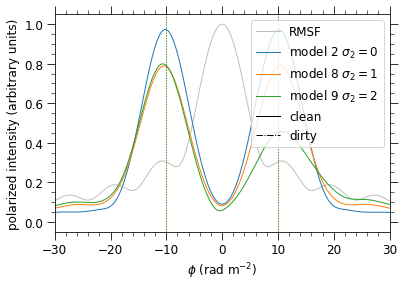

In [27]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

clean_out = sims(ax, freq, -10, 10, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, model_no=2, sigma_1 = 0, sigma_2 = 0, legendsig=True)
clean_out = sims(ax, freq, -10, 10, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, model_no=8, sigma_1 = 1, sigma_2 = 1, legendsig=True)
clean_out = sims(ax, freq, -10, 10, pi_main=1, pi_2=1, psi_2 = 0,
     dirty=False, clean=True, model_no=9, sigma_1 = 1, sigma_2 = 2, legendsig=True)

handles, labels = ax.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='k', linestyle='-', label='clean'))
handles.append(Line2D([0], [0], color='k', linestyle='-.', label='dirty'))

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
#fig.savefig('figures/model_angles.pdf')

5 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $5\arcdeg$ \\
6 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $10\arcdeg$ \\
7 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $15\arcdeg$ \\
8 & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $2 \radmsq$ & $0.0 \radmsq$ & $20\arcdeg$ \\


Text(0, 0.5, 'polarized intensity (arbitrary units)')

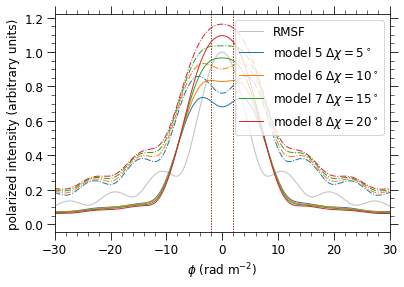

In [28]:
fig, ax = plt.subplots()

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 5*np.pi/180,
     dirty=True, clean=True, model_no=5, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 10*np.pi/180,
     dirty=True, clean=True, model_no=6, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 15*np.pi/180,
     dirty=True, clean=True, model_no=7, legendchi=True)
clean_out = sims(ax, freq, -2, 2, pi_main=1, pi_2=1, psi_2 = 20*np.pi/180,
     dirty=True, clean=True, model_no=8, legendchi=True)

handles, labels = ax.get_legend_handles_labels()

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
#fig.savefig('figures/model_pi.pdf')

0 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
1 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-4 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
2 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-6 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
3 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-8 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
4 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-10 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
5 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-12 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\
6 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-14 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ \\


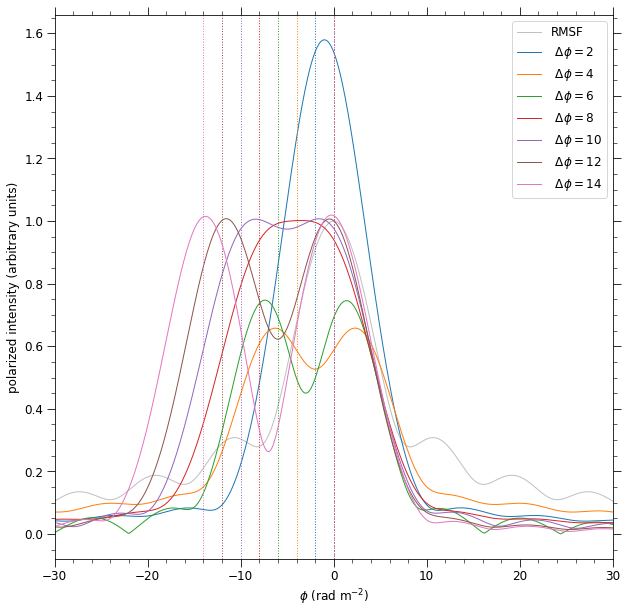

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

for i, fd in enumerate(np.arange(-2, -16, -2)):
    clean_out = sims(ax, freq, 0, fd, pi_main=1, pi_2=1, psi_2 = 0,
         dirty=False, clean=True, model_no=i, legendphi=True, legendnum=False)

handles, labels = ax.get_legend_handles_labels()

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.savefig('figures/model_dphi.pdf')

In [30]:
def sep_model(dchi=0, freq=np.arange(400e6,729e6,390e3),
             minfd=1, maxfd=20, fdstep=0.1, pi2=1):
    fdsep = []
    peak1 = []
    peak2 = []
    for fd in np.arange(minfd, maxfd, fdstep):
        clean_out = sims(0, freq, 0, fd, pi_main=1, pi_2=pi2, psi_2 = dchi,
             dirty=False, clean=True, printtable=False, plot=False)
        fdsep.append(fd)
        peakidx, heights = find_peaks(np.abs(clean_out[1]['cleanFDF']), height=0.5, prominence=0.05)
        if len(peakidx) > 2:
            print('{:.0f} components found for fd {:.1f}'.format(len(peakidx), fd))
        if len(peakidx) == 2:
            peak1.append(clean_out[1]['phiArr_radm2'][peakidx[0]])
            peak2.append(clean_out[1]['phiArr_radm2'][peakidx[1]])
        else:
            peak1.append(np.nan)
            peak2.append(np.nan)
    return np.array(fdsep), np.array(peak1), np.array(peak2)

In [31]:
fdsep0, peak1_0, peak2_0 = sep_model()
fdsep45, peak1_45, peak2_45 = sep_model(dchi=np.pi/4)
fdsep90, peak1_90, peak2_90 = sep_model(dchi=np.pi/2)

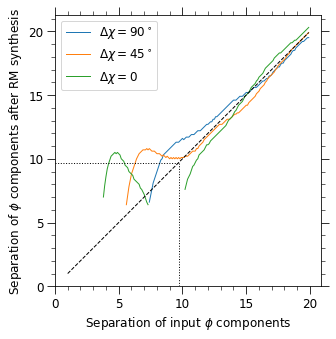

In [32]:
fig, ax = plt.subplots(figsize=(5,5))

peaksep90 = np.abs(peak2_90 - peak1_90)
peaksep45 = np.abs(peak2_45 - peak1_45)
peaksep0 = np.abs(peak2_0 - peak1_0)

ax.plot(np.abs(fdsep90), peaksep90, '-', label='$\Delta \chi = 90^\circ$')
ax.plot(np.abs(fdsep45), peaksep45, '-', label='$\Delta \chi = 45^\circ$')
ax.plot(np.abs(fdsep0), peaksep0, '-', label='$\Delta \chi = 0$')
ax.plot(fdsep90, fdsep90, 'k--')
ax.set_aspect(1)
ax.set_xlabel('Separation of input $\phi$ components')
ax.set_ylabel('Separation of $\phi$ components after RM synthesis')
ax.legend()
ax.plot([0,9.7],[9.7,9.7], linestyle=':', color='k')
ax.plot([9.7,9.7],[0,9.7], linestyle=':', color='k')
ax.set_xlim(0)
ax.set_ylim(0)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
fig.savefig('figures/peak_separation_phi.pdf')

0 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-2 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
1 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-4 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
2 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-6 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
3 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-8 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
4 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-10 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
5 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-12 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\
6 & $1.0$ & $0 \radmsq$ & $0.0 \radmsq$ & $0\arcdeg$ & $1.0$ & $-14 \radmsq$ & $0.0 \radmsq$ & $90\arcdeg$ \\


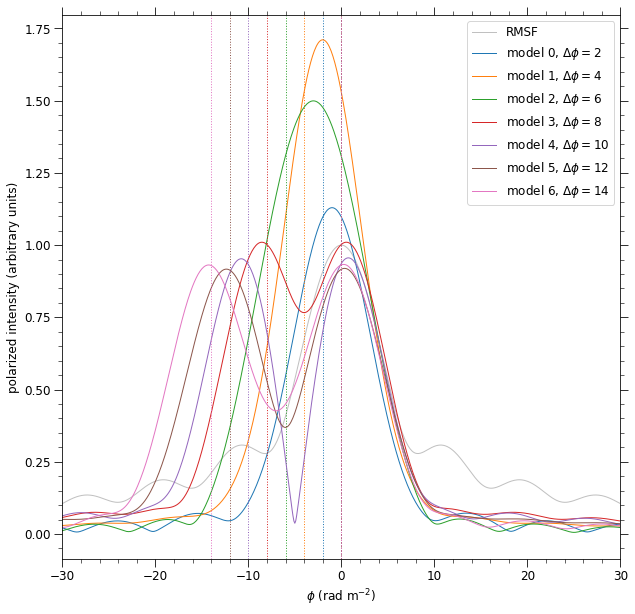

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(rmsfplanes_out[1], np.abs(rmsfplanes_out[0]), '#c0c0c0', label='RMSF')

for i, fd in enumerate(np.arange(-2, -16, -2)):
    clean_out = sims(ax, freq, 0, fd, pi_main=1, pi_2=1, psi_2 = np.pi/2,
         dirty=False, clean=True, model_no=i)

handles, labels = ax.get_legend_handles_labels()

ax.set_xlim(-30, 30)
ax.legend(handles=handles)

ax.set_xlabel('$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('polarized intensity (arbitrary units)')
fig.savefig('figures/model_dphi_pi2.pdf')